# PI-LSTM + Holt-Winters

Training: **2023–2024**  
Forecast: **01/2025–06/2025**

This notebook was written to be used in a **graduate / master’s degree** context, with detailed comments explaining each step of the forecasting pipeline.

## Objectives

1. Load a demand time series from the `dados.csv` file.
2. Aggregate the time series on a **monthly** basis.
3. Split the data into a **training** period (2023-01 to 2024-12) and a **test** period (2025-01 to 2025-06).
4. Fit a **Holt-Winters** physical model (trend + seasonality).
5. Fit a **PI-LSTM** (Physics-Informed LSTM) model, whose **loss** function combines the error with respect to the observed data and the error with respect to the physical model.
6. Perform a **multi-step forecast** (6 months) from January/2025 to June/2025.
7. Perform a **sweep over multiple alpha values** (from 0.0 to 1.0), where alpha controls the weight of the physical component in the loss function.
8. Generate an Excel file containing numerical results for each alpha value, including metrics and forecasts.
9. Generate plots for analysis.

The central idea of the PI-LSTM approach is to incorporate knowledge from the physical model (Holt-Winters) into the neural network training process, creating a **hybrid loss**:

$$\mathcal{L}_{total} = (1 - \alpha) \cdot \mathcal{L}_{data} + \alpha \cdot \mathcal{L}_{physics}$$

where:
- $\mathcal{L}_{data}$ is the LSTM error with respect to the observed data;
- $\mathcal{L}_{physics}$ is the LSTM error with respect to the Holt-Winters forecasts;
- $\alpha \in [0,1]$ controls how strongly the model should adhere to the behavior of the physical model.


In [1]:
import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing

print("Versions:")
print("  pandas:", pd.__version__)
print("  numpy:", np.__version__)
print("  torch:", torch.__version__)


Versions:
  pandas: 2.3.3
  numpy: 2.3.5
  torch: 2.9.1+cpu


## 1. Reproducibility of the experiments

In scientific experiments, it is important that the results are **reproducible**, that is, that the same code, using the same data, produces identical or very similar results.

For this purpose, we define a function that sets the random number generator seeds for Python, NumPy, and PyTorch.

In [2]:
def set_reproducibility(seed: int = 152):
    """Configures random seeds for reproducibility.

    Parameters
    ----------
    seed : int
        Random seed value.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


# Chamamos a função uma vez no início do notebook
set_reproducibility(152)
print("Seeds configured.")


Seeds configured.


## 2. Data loading and initial inspection

We assume that a file named **`dados.csv`** exists in the same directory as this notebook.  
At a minimum, we expect two columns:

- `DT_MVTO_ESTOQUE`: movement date (e.g., daily);
- `QUANTIDADE`: moved quantity (demand, consumption, etc.).

If the column names differ, the code below must be adjusted accordingly.

In [3]:
path_csv = "data/data.csv"  # name entered

# 1) Read the CSV file, attempting to automatically detect the separator
#    (if your file is separated by ';' instead of ',', this resolves the issue)
df = pd.read_csv(path_csv, sep=None, engine="python")

print("Columns read from the CSV (before any adjustments):")
for c in df.columns:
    print(repr(c))

# 2) Remove whitespace and hidden characters from the beginning/end of the name
df.columns = df.columns.str.strip()

print("\nColumns after strip():")
for c in df.columns:
    print(repr(c))

# 3) Ensure that the DT_MVTO_ESTOQUE column exists.
if "DT_MVTO_ESTOQUE" not in df.columns:
    # Try to find an 'equivalent' column ignoring case sensitivity
    candidates_date = [c for c in df.columns if c.upper() == "DT_MVTO_ESTOQUE"]
    if candidates_date:
        df = df.rename(columns={candidates_date[0]: "DT_MVTO_ESTOQUE"})
    else:
        raise KeyError(
            f"I couldn't find the 'DT_MVTO_ESTOQUE' column in the DataFrame.\n"
            f"Columns read: {df.columns.tolist()}"
        )

#4) Same idea for QUANTITY (if it comes as 'quantity', 'Quantity', etc.)
if "QUANTIDADE" not in df.columns:
    candidates_qtd = [c for c in df.columns if "QUANT" in c.upper()]
    if candidates_qtd:
        df = df.rename(columns={candidates_qtd[0]: "QUANTIDADE"})
    else:
        raise KeyError(
            f"I couldn't find the 'QUANTITY' column in the DataFrame.\n"
            f"Columns read: {df.columns.tolist()}"
        )

# 5) Convert the date column (Brazilian format: dd/mm/yyyy) and sort it.
df["DT_MVTO_ESTOQUE"] = pd.to_datetime(
    df["DT_MVTO_ESTOQUE"],
    dayfirst=True,        # explicitly states that the first field is the day
    format="%d/%m/%Y"     # ensures that pandas won't infer incorrectly
)

df = df.sort_values("DT_MVTO_ESTOQUE").reset_index(drop=True)

print("\nFinal columns in the DataFrame:")
print(df.columns.tolist())

df.head()


Columns read from the CSV (before any adjustments):
'   '
'DT_MVTO_ESTOQUE'
'QUANTIDADE'

Columns after strip():
''
'DT_MVTO_ESTOQUE'
'QUANTIDADE'

Final columns in the DataFrame:
['', 'DT_MVTO_ESTOQUE', 'QUANTIDADE']


,,DT_MVTO_ESTOQUE,QUANTIDADE
0,331,2023-01-03,225
1,379,2023-01-04,160
2,197,2023-01-09,25
3,46,2023-01-10,225
4,238,2023-01-11,225


## 3. Monthly aggregation of the time series

We work with demand on a **monthly** basis, summing the quantities over each month.

We use the pandas `resample('M')` function, which groups the data by month-end.

In [4]:
df_mensal = (
    df.set_index('DT_MVTO_ESTOQUE')
      .resample('M')['QUANTIDADE']
      .sum()
      .reset_index()
)

# Fills in any missing values ​​with 0
df_mensal['QUANTIDADE'] = df_mensal['QUANTIDADE'].fillna(0.0)

# Creates a month column (1..12) for explicit capture of monthly seasonality.
df_mensal['MES'] = df_mensal['DT_MVTO_ESTOQUE'].dt.month.astype(int)

print("Monthly series size:", df_mensal.shape)
display(df_mensal.head())
display(df_mensal.tail())

Monthly series size: (36, 3)


C:\Users\anderson.gomes\AppData\Local\Temp\ipykernel_8888\3206004594.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['QUANTIDADE']


,DT_MVTO_ESTOQUE,QUANTIDADE,MES
0,2023-01-31,2015,1
1,2023-02-28,1675,2
2,2023-03-31,2115,3
3,2023-04-30,1505,4
4,2023-05-31,2430,5


,DT_MVTO_ESTOQUE,QUANTIDADE,MES
31,2025-08-31,1325,8
32,2025-09-30,1055,9
33,2025-10-31,1050,10
34,2025-11-30,1920,11
35,2025-12-31,350,12


## 4. Definition of training and test periods

For the master’s degree experiment, we define:

- **Training**: from **01/01/2023** to **31/12/2024**  
- **Test / evaluation**: from **01/01/2025** to **30/06/2025** (6 months)

This test window is used to evaluate the quality of the forecasts generated for the 6-month horizon.

In [5]:
train_mask = (
    (df_mensal['DT_MVTO_ESTOQUE'] >= '2023-01-01') &
    (df_mensal['DT_MVTO_ESTOQUE'] <= '2024-12-31')
)

test_mask = (
    (df_mensal['DT_MVTO_ESTOQUE'] >= '2025-01-01') &
    (df_mensal['DT_MVTO_ESTOQUE'] <= '2025-06-30')
)

train_df = df_mensal[train_mask].copy().reset_index(drop=True)
test_df  = df_mensal[test_mask].copy().reset_index(drop=True)

# Forecast horizon (number of months in test)
H = len(test_df)

print("Months of training:", train_df.shape[0])
print("Months of testing (expected 6):", H)
display(train_df.tail())
display(test_df)


Months of training: 24
Months of testing (expected 6): 6


,DT_MVTO_ESTOQUE,QUANTIDADE,MES
19,2024-08-31,1840,8
20,2024-09-30,1695,9
21,2024-10-31,1600,10
22,2024-11-30,475,11
23,2024-12-31,1400,12


,DT_MVTO_ESTOQUE,QUANTIDADE,MES
0,2025-01-31,1015,1
1,2025-02-28,1715,2
2,2025-03-31,1380,3
3,2025-04-30,1250,4
4,2025-05-31,1375,5
5,2025-06-30,1495,6


## 5. Holt-Winters physical model

The Holt-Winters model is a classical time series model that incorporates:

- level (mean component),
- trend (growth/decline),
- seasonality (a repeating pattern, e.g., yearly).

We use the additive version (`trend='add'`, `seasonal='add'`) with a seasonal period of 12 months, which is appropriate for monthly data.

The Holt-Winters output is used in two ways:
1. As a **physical baseline** (pure Holt-Winters forecast for 2025-01 to 2025-06);
2. As a reference for the **physical loss** in the PI-LSTM.

In [6]:
hw_model = ExponentialSmoothing(
    train_df['QUANTIDADE'],
    seasonal_periods=12,   # Monthly data: 12 months ~ 1 year
    trend='add',
    seasonal='add',
    initialization_method="estimated"
).fit()

# Values ​​adjusted by the physical model during the training period
train_df['HW_Fitted'] = hw_model.fittedvalues

# Physical forecast for the test horizon (Jan–Jun/2025)
hw_forecast_6m = hw_model.forecast(H)

print("Holt-Winters forecast for Jan–Jun/2025:")
print(hw_forecast_6m.values)

train_df.tail()


Holt-Winters forecast for Jan–Jun/2025:
[1267.0103264  1311.99739165 1632.00710981 1041.9970676  1569.49313586
 1163.9955998 ]


,DT_MVTO_ESTOQUE,QUANTIDADE,MES,HW_Fitted
19,2024-08-31,1840,8,2062.002978
20,2024-09-30,1695,9,1538.993973
21,2024-10-31,1600,10,1751.001097
22,2024-11-30,475,11,1241.508803
23,2024-12-31,1400,12,1236.500828


## 6. Normalization and creation of sliding windows

Neural networks (such as LSTMs) generally train better when the input data are **normalized** (e.g., within the \[0, 1\] range).

Here:
- We apply `MinMaxScaler` to two columns:
  - `QUANTIDADE` (observed values)
  - `HW_Fitted` (physical values fitted by the Holt-Winters model)
- We create temporal windows of length `SEQ_LENGTH` (e.g., 12 months).  
Each input window contains 12 demand values, and the **target** (y) is the subsequent value (next month):

- `X` = [QUANTIDADE_t, QUANTIDADE_{t+1}, ..., QUANTIDADE_{t+11}]
- `y_true` = QUANTIDADE_{t+12}
- `y_phy` = HW_Fitted_{t+12}

These two outputs (`y_true` and `y_phy`) are used in the hybrid loss of the PI-LSTM.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Training matrix with the columns: [QUANTITY, HW_Fitted, MES]
# The MES column shows the monthly seasonality (1..12) for the PI-LSTM.
data_train_raw = train_df[['QUANTIDADE', 'HW_Fitted', 'MES']].values

# Ajuste e transformação para o intervalo [0,1]
data_train_scaled = scaler.fit_transform(data_train_raw)

def create_sliding_windows(data: np.ndarray, seq_length: int):
    """Creates sliding windows for LSTM training.

    Parameters
    ----------
    data : np.ndarray
        Normalized data, with columns [QUANTIDADE_norm, HW_Fitted_norm, MES_norm].
    seq_length : int
        Entry window size (number of months elapsed).

    Returns
    -------
    X : np.ndarray
        Input sequences of size (N, seq_length, 2), using
        QUANTIDADE_norm and MES_norm as features of PI-LSTM.
    y_true : np.ndarray
        Next normalized QUANTITY value.
    y_phy : np.ndarray
        Next normalized value of HW_Fitted.
    """
    xs, ys_true, ys_phy = [], [], []
    for i in range(len(data) - seq_length):
        janela = data[i:i+seq_length]
        # Input features: normalized quantity (col 0) + normalized month (col 2)
        x = np.stack([janela[:, 0], janela[:, 2]], axis=1)
        y_t = data[i+seq_length, 0]   # next real value(QUANTIDADE_norm)
        y_p = data[i+seq_length, 1]   # next physical value (HW_Fitted_norm)
        xs.append(x)
        ys_true.append(y_t)
        ys_phy.append(y_p)
    return np.array(xs), np.array(ys_true), np.array(ys_phy)

# Historical window size (12 months)
SEQ_LENGTH = 12

X_train_np, y_train_real_np, y_train_phy_np = create_sliding_windows(
    data_train_scaled,
    seq_length=SEQ_LENGTH
)

# Converts to PyTorch tensors; now each time step has 2 features.
# (QUANTIDADE_norm, MES_norm), therefore, extra unsqueeze is not necessary.
X_train      = torch.from_numpy(X_train_np).float()
y_train_real = torch.from_numpy(y_train_real_np).float().unsqueeze(-1)
y_train_phy  = torch.from_numpy(y_train_phy_np).float().unsqueeze(-1)

print("X_train format:", X_train.shape)       # (batch, seq_length, 2)
print("y_train_real format:", y_train_real.shape)
print("y_train_phy format:", y_train_phy.shape)


X_train format: torch.Size([12, 12, 2])
y_train_real format: torch.Size([12, 1])
y_train_phy format: torch.Size([12, 1])


## 7. PI-LSTM architecture and EarlyStopping ("stop loss")

The adopted architecture is a **simple LSTM** composed of:
- 1 LSTM layer with `hidden_size=128` neurons;
- a `Dropout` layer (to reduce overfitting);
- a fully connected (`Linear`) layer to map the hidden state to a single output value (the predicted demand).

We also implement a simple **EarlyStopping** mechanism:
- The loss is monitored across epochs;
- If the loss does not improve after `patience` epochs, training is stopped and the best model weights are restored.

This mechanism acts as a form of **"stop loss" during training**, preventing excessive overfitting and unnecessary computational cost.

In [8]:
class PILSTM(nn.Module):
    """Implementation of a simple LSTM for time series forecasting.

    The idea is that this network is informed by a physical model via hybrid loss,
    but the architecture itself is a conventional single-layer LSTM.
    """
    def __init__(self, input_size: int = 2, hidden_size: int = 128, num_layers: int = 1):
        super(PILSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.10)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch, seq_length, input_size)
        out, _ = self.lstm(x)
        # It only captures the output of the last temporal step.
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out


class EarlyStopping:
    """Early stopping mechanism based on loss evolution.

    If the loss does not improve after 'patience' periods, we set early_stop = True
    and save the best weight state to restore later.
    """
    def __init__(self, patience: int = 20, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_loss: float, model: nn.Module):
        # Update if it's the first time or if the loss has improved beyond the threshold.
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model: nn.Module):
        """Restores the optimal weights observed during training."""
        if self.best_model_state is not None:
            model.load_state_dict(self.best_model_state)


## 8. Training function per alpha value (hybrid loss)

We now define the training function `treinar_pi_lstm_alpha`, which takes a value of **alpha** and trains the PI-LSTM network using a hybrid loss:

$$\mathcal{L}_{total} = (1 - \alpha) \cdot \text{MSE}(y_{pred}, y_{real}) + \alpha \cdot \text{MSE}(y_{pred}, y_{physical})$$

where:
- `y_real` is the normalized observed value (`y_train_real`),
- `y_phy` is the normalized physical value (`y_train_phy`).

At the end, the function returns:
- the trained model,
- the final total loss,
- the data loss,
- the physical loss.

In [9]:
criterion = nn.MSELoss()

def treinar_pi_lstm_alpha(alpha: float, epochs: int = 300, lr: float = 0.003):
    """Train the PI-LSTM for a given value of alpha.

    Parameters
    ----------
    alpha : float
        Weight of physical loss in total loss (between 0 and 1).
    epochs : int
        Maximum number of training periods.
    lr : float
        Adam optimizer learning rate.
    """

    # Ensures reproducibility through alpha
    set_reproducibility(152)

    model = PILSTM(input_size=2, hidden_size=790, num_layers=2)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    early_stopping = EarlyStopping(patience=30, min_delta=1e-4)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        y_pred = model(X_train)

        loss_data = criterion(y_pred, y_train_real)
        loss_phy  = criterion(y_pred, y_train_phy)
        loss_total = (1 - alpha) * loss_data + alpha * loss_phy

        loss_total.backward()
        optimizer.step()

        # Update early stopping
        early_stopping(loss_total.item(), model)
        if early_stopping.early_stop:
            print(f"Early stopping for alpha={alpha} at epoch {epoch}")
            break

    # Restores optimal weights
    early_stopping.restore_best_weights(model)

    # Calculates the final losses in the training set
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        final_data_loss = criterion(y_pred, y_train_real).item()
        final_phy_loss  = criterion(y_pred, y_train_phy).item()
        final_total_loss = (1 - alpha) * final_data_loss + alpha * final_phy_loss

    return model, final_total_loss, final_data_loss, final_phy_loss


## 9. Multi-step forecasting (Jan–Jun/2025) with PI-LSTM

Multi-step forecasting is performed in a **recursive** manner:

1. We start with an initial window containing the **last `SEQ_LENGTH` months of the training period**.
2. The PI-LSTM predicts the next month (t+1).
3. This predicted value is:
   - denormalized (mapped back to the original scale);
   - constrained to be non-negative (a simple physical constraint for demand);
   - used to update the input window, together with the Holt-Winters physical forecast for the same month.
4. The process is repeated until forecasts are obtained for the 6 months of interest (Jan–Jun/2025).

At the end, the function returns:
- `preds_pi`: a vector containing the PI-LSTM forecasts;
- `hw_future`: a vector containing the Holt-Winters forecasts for the same months.


In [10]:
def forecast_pi_lstm_multistep(
    model: nn.Module,
    scaler: MinMaxScaler,
    train_df: pd.DataFrame,
    hw_model: ExponentialSmoothing,
    seq_length: int,
    horizon: int
):
    """
    It performs multi-step forecasting (horizon of months) with PI-LSTM.

    The forecast is recursive: the forecast for one month is used as input for the next.
    In addition, we use Holt-Winters forecasts in the window update.

    The PI-LSTM explicitly receives two features per time step:
    - Normalized QUANTITY;
    - Normalized month index (MES_norm), to capture seasonality.
    """

    # Last available date in the training period (to advance the calendar)
    last_date = train_df['DT_MVTO_ESTOQUE'].iloc[-1]

    # Initial window: last 'seq_length' months of the training period
    last_q   = train_df['QUANTIDADE'].iloc[-seq_length:].values
    last_hw  = train_df['HW_Fitted'].iloc[-seq_length:].values
    last_mes = train_df['MES'].iloc[-seq_length:].values

    # The scaler was adjusted in three columns [QUANTITY, HW_Fitted, MES]
    dummy = np.zeros((seq_length, 3))
    dummy[:, 0] = last_q
    dummy[:, 1] = last_hw
    dummy[:, 2] = last_mes
    dummy_scaled = scaler.transform(dummy)

    # Network input sequence: (seq_length, 2) -> [QUANTITY_norm, MES_norm]
    seq_scaled = np.stack([dummy_scaled[:, 0], dummy_scaled[:, 2]], axis=1)

    preds_pi = []
    hw_future = hw_model.forecast(horizon)  # Pandas series with future physical values

    model.eval()
    for h in range(horizon):
        # Prepares input tensor with shape (1, seq_length, 2)
        x = torch.from_numpy(seq_scaled.reshape(1, seq_length, 2)).float()
        with torch.no_grad():
            y_scaled = model(x).item()

        # Denormalizes the network forecast (QUANTITY column only)
        dummy_out = np.zeros((1, 3))
        dummy_out[0, 0] = y_scaled
        y_inv = scaler.inverse_transform(dummy_out)[0, 0]

        # Physical constraint: non-negative demand
        y_inv = max(0, y_inv)
        preds_pi.append(y_inv)

        # Predicted physical value (Holt-Winters) for this step
        hw_val = hw_future.iloc[h]

        # Month corresponding to this future step.
        future_date = last_date + pd.DateOffset(months=h + 1)
        mes_future = future_date.month

        # Assemble a sample with the 3 columns expected by the scaler.
        dummy_next = np.zeros((1, 3))
        dummy_next[0, 0] = y_inv
        dummy_next[0, 1] = hw_val
        dummy_next[0, 2] = mes_future
        scaled_next = scaler.transform(dummy_next)[0]

        # Update the sliding window with (QUANTITY_norm, MONTH_norm)
        seq_scaled = np.roll(seq_scaled, -1, axis=0)
        seq_scaled[-1, 0] = scaled_next[0]  # QUANTIDADE_norm
        seq_scaled[-1, 1] = scaled_next[2]  # MES_norm

    # Converting to NumPy arrays simplifies later use.
    return np.array(preds_pi), np.array(hw_future.values)


## 10. Evaluation metrics over the 6-month horizon

To assess the quality of the forecasts over the test period (Jan–Jun/2025), we use:

- **MAE** (Mean Absolute Error): the average absolute error;
- **RMSE** (Root Mean Squared Error): the square root of the mean squared error;
- **MAPE** (Mean Absolute Percentage Error): the mean absolute percentage error (in %), ignoring points where the true value is zero.

These metrics are computed by comparing the PI-LSTM forecasts with the observed values from 2025-01 to 2025-06.

In [11]:
def calcular_metricas(y_true, y_pred):
    """Calculate MAE, RMSE, and MAPE between vectors y_true and y_pred."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    if n == 0:
        return np.nan, np.nan, np.nan

    erros = y_pred - y_true
    mae = np.mean(np.abs(erros))
    rmse = math.sqrt(np.mean(erros ** 2))

    # MAPE: only at points where y_true > 0
    mask = y_true != 0
    if mask.any():
        mape = np.mean(np.abs(erros[mask] / y_true[mask])) * 100
    else:
        mape = np.nan

    return mae, rmse, mape


## 11. Alpha sweep and Excel spreadsheet generation

We now conduct the main experiment:

1. We define a list of alpha values from 0.0 to 1.0 (step size of 0.1).
2. For each alpha:
   - A specific PI-LSTM model is trained;
   - PI-LSTM forecasts are generated for Jan–Jun/2025;
   - Evaluation metrics (MAE, RMSE, MAPE) are computed over the 6-month horizon;
   - Month-by-month **observed**, **Holt-Winters**, and **PI-LSTM** forecasts are also stored.
3. Finally, all results are consolidated into a `DataFrame` and saved to an Excel file:
   - **`resultados_pi_lstm_alphas_2023_2025.xlsx`**

This Excel file can be attached to research reports, facilitating a comparative analysis across different alpha values.

In [12]:
# Defining alphas from 0.0 to 1.0, step 0.1
alpha_values = [round(a, 1) for a in np.linspace(0.0, 1.0, 11)]

results_rows = []

# Vector of real values ​​in the test horizon (Jan–Jun/2025)
y_real_6m = test_df['QUANTIDADE'].values
H = len(y_real_6m)

print("Actual values ​​(Jan–Jun/2025):", y_real_6m)
print("H (number of months on trial):", H)

if H == 0:
    raise RuntimeError(
        "There are no months in the testing period (2025-01 to 2025-06)."
        "Verify that df_mensal actually contains data in that interval."
    )

for alpha in alpha_values:
    print(f"\nTraining PI-LSTM model for alpha={alpha}...")

    # 1) Train the model for this alpha.
    model, final_loss, data_loss, phy_loss = treinar_pi_lstm_alpha(alpha)

    # 2) Multi-step forecast (Jan–Jun/2025)
    pi_forecast_6m, hw_forecast_6m = forecast_pi_lstm_multistep(
        model=model,
        scaler=scaler,
        train_df=train_df,
        hw_model=hw_model,
        seq_length=SEQ_LENGTH,
        horizon=H
    )

    # It ensures that we won't index beyond the size of each vector.
    H_eff = min(H, len(pi_forecast_6m), len(hw_forecast_6m))

    if H_eff == 0:
        raise RuntimeError(
            f"The prediction returned empty vectors for alpha={alpha}. "
            "Check the forecast_pi_lstm_multistep function."
        )

    # Consistent cutouts
    y_real = y_real_6m[:H_eff]
    y_pi   = pi_forecast_6m[:H_eff]
    y_hw   = hw_forecast_6m[:H_eff]

    # 3) Aggregate metrics for the horizon
    mae, rmse, mape = calcular_metricas(y_real, y_pi)

    # 4) Establish a baseline for the spreadsheet (aggregate metrics).
    row = {
        "alpha": alpha,
        "train_loss_total": final_loss,
        "train_loss_data": data_loss,
        "train_loss_phy": phy_loss,
        "mae_6m": mae,
        "rmse_6m": rmse,
        "mape_6m_%": mape,
    }

    # 5) Actual values, physical values, PI-LSTM, and month-to-month errors.
    erros_pi = y_pi - y_real
    erros_hw = y_hw - y_real

    for i in range(H_eff):
        real_i = float(y_real[i])
        pi_i   = float(y_pi[i])
        hw_i   = float(y_hw[i])
        errpi_i  = float(erros_pi[i])
        errhw_i = float(erros_hw[i])

        # A percentage error only makes sense if the actual value is different from zero.
        if real_i != 0:
            errpi_perc_i = float(errpi_i / real_i * 100.0)
            errhw_perc_i = float(errhw_i / real_i * 100.0)
        else:
            errpi_perc_i = np.nan
            errhw_perc_i = np.nan

        # Reference values
        row[f"real_mes_{i+1}"] = real_i
        row[f"hw_mes_{i+1}"]   = hw_i
        
        # Absolute and percentage error this month
        row[f"erro_hw_mes_{i+1}"]        = errhw_i
        row[f"erro_hw_perc_mes_{i+1}_%"] = errhw_perc_i
        
        row[f"pi_mes_{i+1}"]   = pi_i

        # Absolute and percentage error this month
        row[f"erro_pi_mes_{i+1}"]        = errpi_i
        row[f"erro_pi_perc_mes_{i+1}_%"] = errpi_perc_i



    results_rows.append(row)

    # Release the model from memory before the next alpha (optional, helps on machines with low RAM)
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Build the final results DataFrame.
results_df = pd.DataFrame(results_rows)

# Salva em arquivo – se não tiver openpyxl, pode trocar para CSV
OUTPUT_FILE_NAME = "results_pi_lstm_alphas_2023_2025.csv"
results_df.to_csv(OUTPUT_FILE_NAME, index=False)

print("\nGenerated file:", OUTPUT_FILE_NAME)
results_df.head()


Actual values ​​(Jan–Jun/2025): [1015 1715 1380 1250 1375 1495]
H (number of months on trial): 6

Training PI-LSTM model for alpha=0.0...
Early stopping for alpha=0.0 at epoch 95

Training PI-LSTM model for alpha=0.1...
Early stopping for alpha=0.1 at epoch 99

Training PI-LSTM model for alpha=0.2...
Early stopping for alpha=0.2 at epoch 70

Training PI-LSTM model for alpha=0.3...
Early stopping for alpha=0.3 at epoch 36

Training PI-LSTM model for alpha=0.4...
Early stopping for alpha=0.4 at epoch 36

Training PI-LSTM model for alpha=0.5...
Early stopping for alpha=0.5 at epoch 36

Training PI-LSTM model for alpha=0.6...
Early stopping for alpha=0.6 at epoch 36

Training PI-LSTM model for alpha=0.7...
Early stopping for alpha=0.7 at epoch 36

Training PI-LSTM model for alpha=0.8...
Early stopping for alpha=0.8 at epoch 138

Training PI-LSTM model for alpha=0.9...
Early stopping for alpha=0.9 at epoch 100

Training PI-LSTM model for alpha=1.0...
Early stopping for alpha=1.0 at epoch 63

,alpha,train_loss_total,train_loss_data,train_loss_phy,mae_6m,rmse_6m,mape_6m_%,real_mes_1,hw_mes_1,erro_hw_mes_1,...,pi_mes_5,erro_pi_mes_5,erro_pi_perc_mes_5_%,real_mes_6,hw_mes_6,erro_hw_mes_6,erro_hw_perc_mes_6_%,pi_mes_6,erro_pi_mes_6,erro_pi_perc_mes_6_%
0,0.0,0.017895,0.017895,0.073925,268.444617,308.484228,20.591365,1015.0,1267.010326,252.010326,...,1642.171326,267.171326,19.430642,1495.0,1163.9956,-331.0044,-22.140763,1707.711316,212.711316,14.228182
1,0.1,0.023563,0.016027,0.091389,361.511102,395.642050,28.127234,1015.0,1267.010326,252.010326,...,1712.618159,337.618159,24.554048,1495.0,1163.9956,-331.0044,-22.140763,1921.108177,426.108177,28.502219
2,0.2,0.037711,0.031482,0.062626,225.076516,250.363104,17.769663,1015.0,1267.010326,252.010326,...,1563.320878,188.320878,13.696064,1495.0,1163.9956,-331.0044,-22.140763,1526.614255,31.614255,2.114666
3,0.3,0.037903,0.029988,0.056370,290.008578,305.300863,22.208221,1015.0,1267.010326,252.010326,...,1715.184352,340.184352,24.740680,1495.0,1163.9956,-331.0044,-22.140763,1656.700007,161.700007,10.816054
4,0.4,0.042414,0.035661,0.052543,237.799574,258.195968,18.107763,1015.0,1267.010326,252.010326,...,1627.158894,252.158894,18.338829,1495.0,1163.9956,-331.0044,-22.140763,1574.242661,79.242661,5.300512


## 12. Visualization of results and comparison between PI-LSTM and Holt-Winters

In this section, plots are generated to help interpret the experiment conducted in Section 11, where a sweep over different values of **alpha** in the hybrid loss was performed:

$$\mathcal{L}_{\text{total}} = (1-\alpha)\,\mathcal{L}_{\text{data}} + \alpha\,\mathcal{L}_{\text{physics}}$$

Recalling:
- $\mathcal{L}_{\text{data}}$ is the PI-LSTM error with respect to the observed data (observed demand);
- $\mathcal{L}_{\text{physics}}$ is the PI-LSTM error with respect to the Holt–Winters physical model;
- $\alpha$ controls the relative weight of the physical model in the total loss.

Based on the `results_df` generated in Section 11, the plots in this section show:

1. **Training loss curves vs. alpha**  
   - `train_loss_total`: total hybrid loss at the end of training;  
   - `train_loss_data`: loss with respect to the observed data;  
   - `train_loss_phy`: loss with respect to the Holt–Winters physical model.  

   These curves illustrate how increasing \(\alpha\) shifts the model’s focus from data adherence to adherence to the physical model.

2. **Generalization metrics over the 6-month horizon vs. alpha**  
   - `mae_6m`, `rmse_6m`, `mape_6m_%` computed between the PI-LSTM forecasts and the observed values (Jan–Jun/2025).  
   This plot allows the identification of the **optimal alpha** in terms of forecasting error (in this notebook, we adopt the minimum 6-month MAPE).

3. **Point-by-point comparison over the test horizon**  
   - The value of **alpha** that minimizes `mape_6m_%` is automatically selected;  
   - For this alpha, the following month-by-month values are compared:
     - Observed (`real_mes_k`);
     - Holt–Winters physical model (`hw_mes_k`);
     - PI-LSTM model (`pi_mes_k`).  

   The line plot shows how the PI-LSTM, informed by the physical model, is able (or not) to reduce the errors of the pure Holt–Winters model throughout the test months.

4. **Numerical summary table (Holt–Winters vs. PI-LSTM)**  
   - For the optimal alpha, the MAE, RMSE, and MAPE metrics are computed and reported for:
     - Holt–Winters (pure physical model);
     - PI-LSTM (hybrid model with the loss $\mathcal{L}_{\text{total}}$).

This combination of plots provides a clearer view of:
- How the parameter $\alpha$ influences PI-LSTM training;
- To what extent the pure physical model (Holt–Winters) is outperformed (or not) by the PI-LSTM model over a seasonal forecasting horizon.

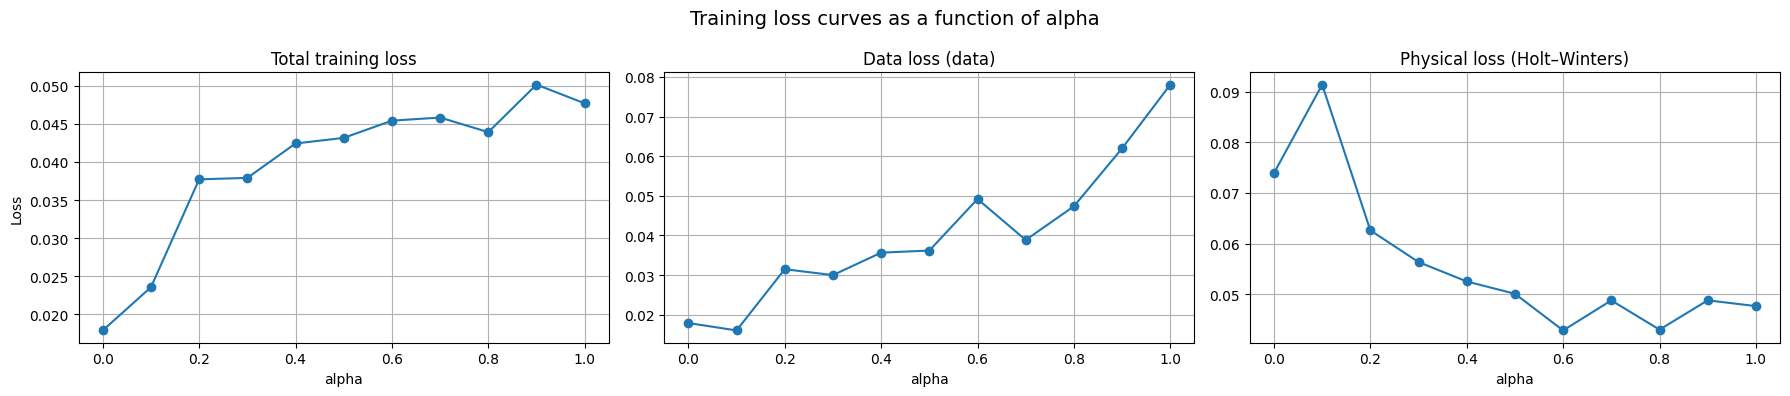

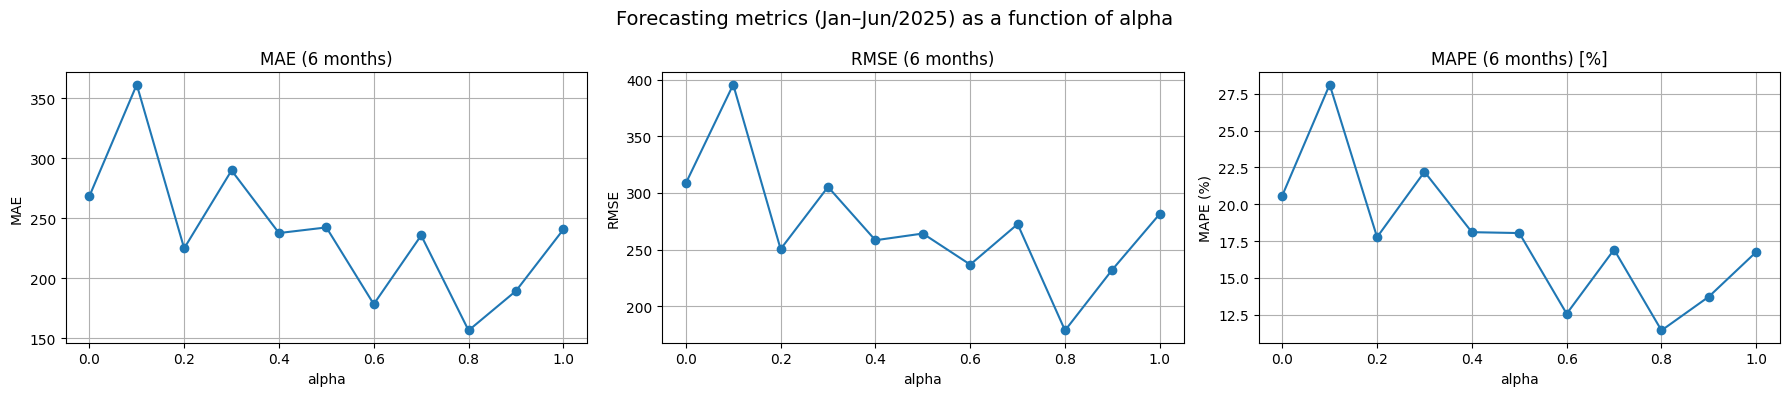

Best alpha (lowest MAPE in 6 months): 0.8 – MAPE = 11.44%


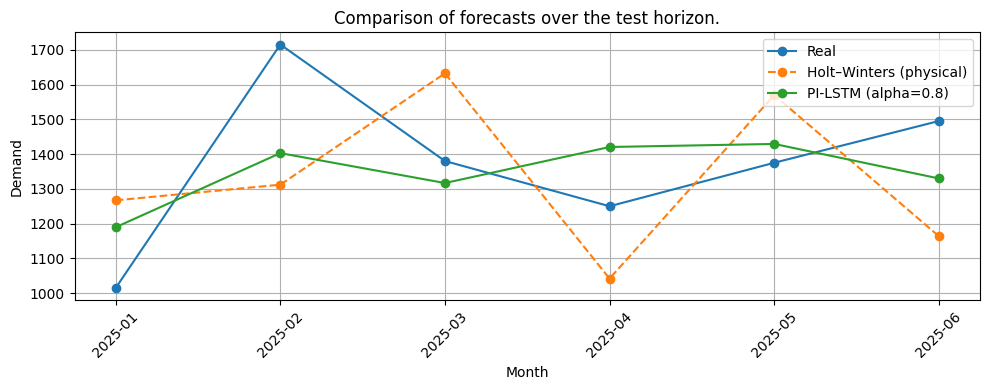

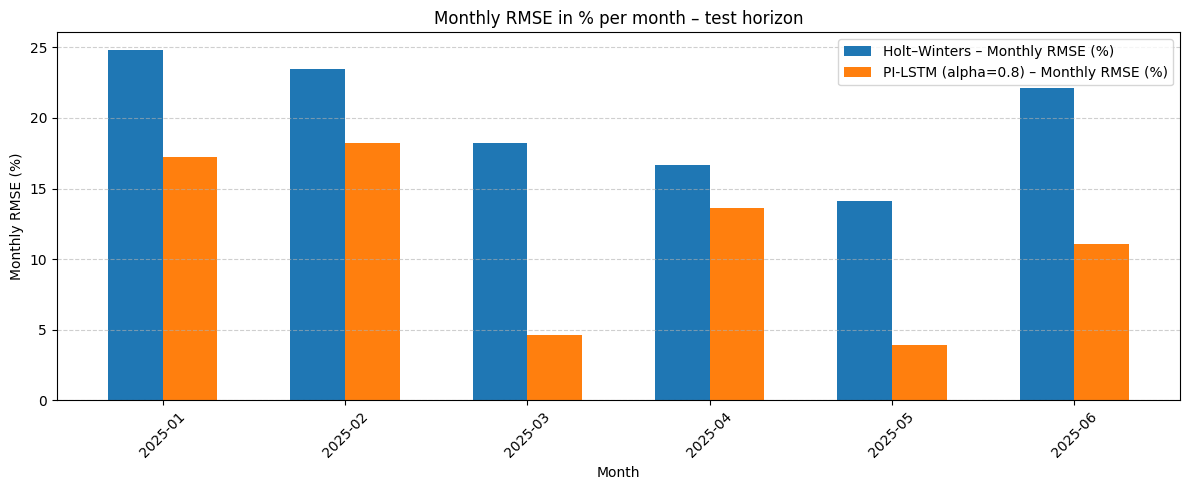


Summary table of performance over the test horizon:


,modelo,MAE_6m,RMSE_6m,RMSE_6m_%,MAPE_6m_%
0,Holt–Winters (physical),273.420,282.868,20.622,19.919
1,PI-LSTM (alpha=0.8),156.637,178.537,13.016,11.436


In [17]:

# -------------------------------------------------------------------------
# Basic checks
# -------------------------------------------------------------------------
if 'results_df' not in globals():
    raise RuntimeError(
        "results_df not found."
        "Make sure you ran the cell from Section 11"
        "(scanning in alphas) ​​before this section."
    )

if 'test_df' not in globals():
    raise RuntimeError(
        "test_df not found."
        "Make sure you have run the data preparation cells"
        "and the train/test split before this section."
    )

# -------------------------------------------------------------------------
# 1) Training vs alpha loss curves
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

axes[0].plot(results_df['alpha'], results_df['train_loss_total'], marker='o')
axes[0].set_title('Total training loss')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('Loss')
axes[0].grid(True)

axes[1].plot(results_df['alpha'], results_df['train_loss_data'], marker='o')
axes[1].set_title('Data loss (data)')
axes[1].set_xlabel('alpha')
axes[1].grid(True)

axes[2].plot(results_df['alpha'], results_df['train_loss_phy'], marker='o')
axes[2].set_title('Physical loss (Holt–Winters)')
axes[2].set_xlabel('alpha')
axes[2].grid(True)

fig.suptitle('Training loss curves as a function of alpha', fontsize=14)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 2) Generalization metrics (6 months) vs alpha
# -------------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

axes[0].plot(results_df['alpha'], results_df['mae_6m'], marker='o')
axes[0].set_title('MAE (6 months)')
axes[0].set_xlabel('alpha')
axes[0].set_ylabel('MAE')
axes[0].grid(True)

axes[1].plot(results_df['alpha'], results_df['rmse_6m'], marker='o')
axes[1].set_title('RMSE (6 months)')
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('RMSE')
axes[1].grid(True)

axes[2].plot(results_df['alpha'], results_df['mape_6m_%'], marker='o')
axes[2].set_title('MAPE (6 months) [%]')
axes[2].set_xlabel('alpha')
axes[2].set_ylabel('MAPE (%)')
axes[2].grid(True)

fig.suptitle('Forecasting metrics (Jan–Jun/2025) as a function of alpha', fontsize=14)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 3) Choosing the optimal alpha (lowest MAPE) and comparing HW vs. PI-LSTM in the test
# -------------------------------------------------------------------------
# Index of the best alpha (lowest 6-month MAPE)
best_idx = results_df['mape_6m_%'].idxmin()
best_row = results_df.loc[best_idx]
best_alpha = float(best_row['alpha'])

print(f"Best alpha (lowest MAPE in 6 months): {best_alpha:.1f} "
      f"– MAPE = {best_row['mape_6m_%']:.2f}%")

# Dynamically discovers how many months were actually used (H_eff)
cols_real = [c for c in results_df.columns if c.startswith("real_mes_")]
cols_hw   = [c for c in results_df.columns if c.startswith("hw_mes_")]
cols_pi   = [c for c in results_df.columns if c.startswith("pi_mes_")]

H_eff = min(len(cols_real), len(cols_hw), len(cols_pi))

# Numerical vectors for optimal alpha
y_real_plot = best_row[cols_real[:H_eff]].values.astype(float)
y_hw_plot   = best_row[cols_hw[:H_eff]].values.astype(float)
y_pi_plot   = best_row[cols_pi[:H_eff]].values.astype(float)

# Test horizon dates (e.g., Jan–Jun/2025)
datas_teste = test_df['DT_MVTO_ESTOQUE'].iloc[:H_eff].dt.strftime('%Y-%m').tolist()

# Comparison chart over the test horizon
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(datas_teste, y_real_plot, marker='o', label='Real')
ax.plot(datas_teste, y_hw_plot,   marker='o', linestyle='--', label='Holt–Winters (physical)')
ax.plot(datas_teste, y_pi_plot,   marker='o', linestyle='-',  label=f'PI-LSTM (alpha={best_alpha:.1f})')

ax.set_title('Comparison of forecasts over the test horizon.')
ax.set_xlabel('Month')
ax.set_ylabel('Demand')
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 4) Monthly RMSE in % per month (Holt-Winters vs PI-LSTM)
#    RMSE_mês(%) = |y_pred - y_real| / y_real * 100
# -------------------------------------------------------------------------
rmse_hw_mes_pct = np.full_like(y_real_plot, fill_value=np.nan, dtype=float)
rmse_pi_mes_pct = np.full_like(y_real_plot, fill_value=np.nan, dtype=float)

mask_nonzero = y_real_plot != 0
rmse_hw_mes_pct[mask_nonzero] = (
    np.sqrt((y_hw_plot[mask_nonzero] - y_real_plot[mask_nonzero])**2)
    / y_real_plot[mask_nonzero] * 100.0
)
rmse_pi_mes_pct[mask_nonzero] = (
    np.sqrt((y_pi_plot[mask_nonzero] - y_real_plot[mask_nonzero])**2)
    / y_real_plot[mask_nonzero] * 100.0
)

fig, ax = plt.subplots(figsize=(12, 5))  # larger graph
indices = np.arange(len(datas_teste))

ax.bar(indices - 0.15, rmse_hw_mes_pct, width=0.3,
       label='Holt–Winters – Monthly RMSE (%)')
ax.bar(indices + 0.15, rmse_pi_mes_pct, width=0.3,
       label=f'PI-LSTM (alpha={best_alpha:.1f}) – Monthly RMSE (%)')

ax.set_title('Monthly RMSE in % per month – test horizon')
ax.set_xlabel('Month')
ax.set_ylabel('Monthly RMSE (%)')
ax.set_xticks(indices)
ax.set_xticklabels(datas_teste, rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------------
# 5) Numerical table: Holt–Winters vs PI-LSTM at optimal alpha
# -------------------------------------------------------------------------
mae_hw,  rmse_hw,  mape_hw  = calcular_metricas(y_real_plot, y_hw_plot)
mae_pi,  rmse_pi,  mape_pi  = calcular_metricas(y_real_plot, y_pi_plot)

# RMSE in % relative to the average of the actual values ​​in the test horizon (6 months)
media_real_6m = y_real_plot.mean()
if media_real_6m == 0:
    rmse_hw_pct_6m = np.nan
    rmse_pi_pct_6m = np.nan
else:
    rmse_hw_pct_6m = rmse_hw / media_real_6m * 100.0
    rmse_pi_pct_6m = rmse_pi / media_real_6m * 100.0

tabela_resumo = pd.DataFrame({
    'modelo': ['Holt–Winters (physical)', f'PI-LSTM (alpha={best_alpha:.1f})'],
    'MAE_6m': [mae_hw, mae_pi],
    'RMSE_6m': [rmse_hw, rmse_pi],
    'RMSE_6m_%': [rmse_hw_pct_6m, rmse_pi_pct_6m],
    'MAPE_6m_%': [mape_hw, mape_pi],
})

print("\nSummary table of performance over the test horizon:")
display(tabela_resumo.round(3))


## 13. LSTM baseline model and comparison with Holt–Winters and PI-LSTM

This section adds an **LSTM baseline model (without physical loss)** at the end of the notebook, keeping all previous cells unchanged.
Training and forecasting follow the same procedure used for the PI-LSTM: **recursive forecasting (month by month) over the 6-month horizon (Jan–Jun/2025)**.


LSTM baseline treinada. Loss de treino (MSE): 0.040080

Summary table of performance over the test horizon (6 months):


,model,MAE_6m,RMSE_6m,MAPE_6m_%
0,Holt–Winters (phisical),273.420,282.868,19.919
1,LSTM (baseline),187.146,246.638,15.452
2,PI-LSTM (best alpha=0.8),156.637,178.537,11.436


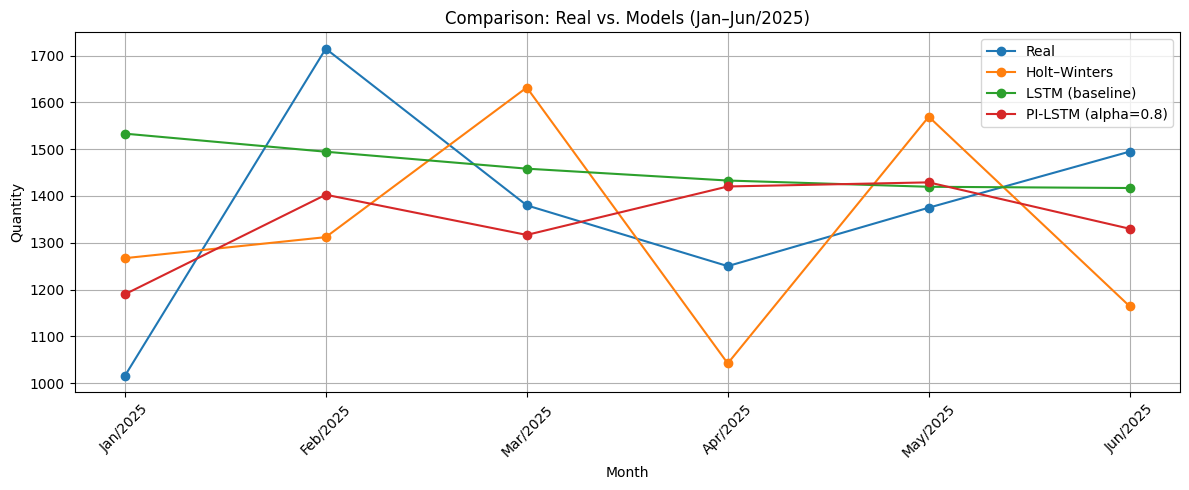

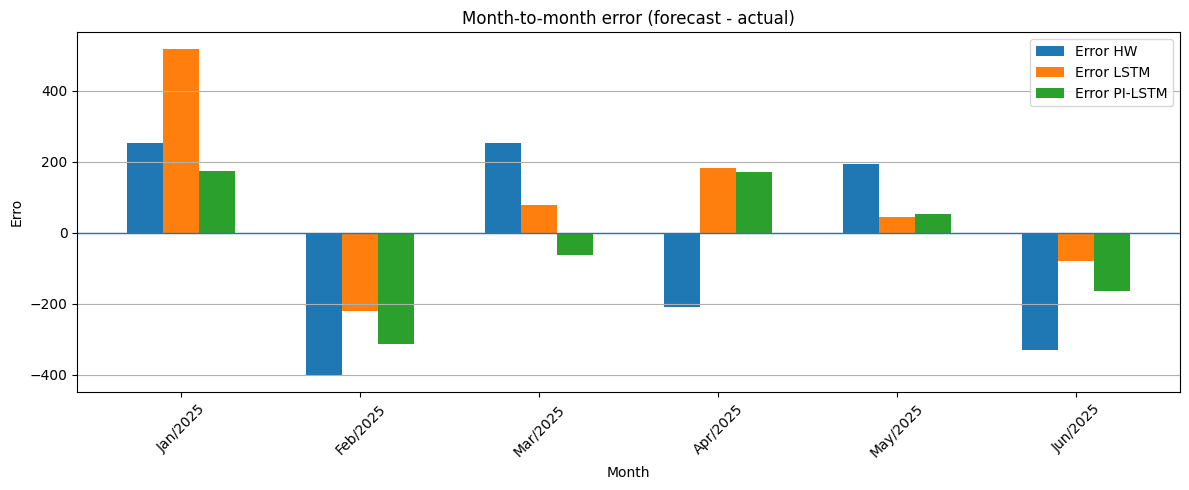

In [14]:

# -------------------------------------------------------------------------
# LSTM baseline (sem loss física) + comparação com Holt–Winters e PI-LSTM
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
# Basic checks (reuse objects created in previous sections)
required = ['train_df', 'test_df', 'SEQ_LENGTH', 'scaler', 'hw_model', 'calcular_metricas', 'PILSTM']
missing = [k for k in required if k not in globals()]
if missing:
    raise RuntimeError(
        "Some variables/functions were not found in the environment: "
        f"{missing}. Complete the previous sections before this one."
    )

# For comparison with PI-LSTM (best alpha), this cell attempts to reuse
# y_pi_plot / y_hw_plot / y_real_plot, in case Section 12 has already been executed.
have_best_pi = all(k in globals() for k in ['y_pi_plot', 'y_hw_plot', 'y_real_plot'])
if not have_best_pi:
    print("Warning: variables for the PI-LSTM vs Holt-Winters comparison were not found "
          "(y_pi_plot/y_hw_plot/y_real_plot). I'll only calculate LSTM vs Holt-Winters/Real.")

# -------------------------------------------------------------------------
# 1) Baseline LSTM training (loss = MSE(y_pred, y_real))
#    Note: We reused the same PILSTM architecture (it's a common LSTM).
# -------------------------------------------------------------------------
criterion = nn.MSELoss()

def treinar_lstm_baseline(epochs: int = 300, lr: float = 0.003):
    #Reproducibility
    set_reproducibility(152)

    model = PILSTM(input_size=2, hidden_size=128, num_layers=1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Early stopping (if the EarlyStopping class exists in the notebook, reuse it; otherwise, full training)
    if 'EarlyStopping' in globals():
        early_stopping = EarlyStopping(patience=20, min_delta=1e-4)
    else:
        early_stopping = None

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train_real)
        loss.backward()
        optimizer.step()

        if early_stopping is not None:
            early_stopping(loss.item(), model)
            if early_stopping.early_stop:
                break

    if early_stopping is not None:
        early_stopping.restore_best_weights(model)

    # Final loss in training
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        final_loss = criterion(y_pred, y_train_real).item()

    return model, final_loss

lstm_model, lstm_train_loss = treinar_lstm_baseline()
print(f"LSTM baseline treinada. Loss de treino (MSE): {lstm_train_loss:.6f}")

# -------------------------------------------------------------------------
# 2) Recursive forecasting (month by month) for 6 months, similar to the PI-LSTM standard.
#    - Features per time step: (QUANTIDADE_norm, MES_norm)
#    - Recursive update: the prediction enters as the next input.
# -------------------------------------------------------------------------
def forecast_lstm_multistep(
    model: nn.Module,
    scaler,
    train_df: pd.DataFrame,
    hw_model,
    seq_length: int,
    horizon: int
):
    '''
    Recursive multi-step forecast (h months) with a standard LSTM.
    Maintains the same normalization scheme as the notebook (scaler in 3 columns),
    filling the HW column only to enable the transform (not used by the model).
    '''
    # Initial window with the last seq_length months of training
    last_window = train_df[['QUANTIDADE', 'HW_Fitted', 'MES']].tail(seq_length).values
    last_scaled = scaler.transform(last_window)

    # Input sequence (seq_length, 2): [QUANTIDADE_norm, MES_norm]
    seq_scaled = np.column_stack([last_scaled[:, 0], last_scaled[:, 2]]).astype(np.float32)

    # Future dates to compose MONTH
    last_date = pd.to_datetime(train_df['DT_MVTO_ESTOQUE'].iloc[-1])

    # Placeholder for the HW column for the scaler (not included in the model)
    hw_future = hw_model.forecast(horizon)

    preds = []
    model.eval()
    for h in range(horizon):
        x = torch.from_numpy(seq_scaled.reshape(1, seq_length, 2)).float()
        with torch.no_grad():
            y_scaled = model(x).item()

        # Denormalizes only QUANTITY (column 0 of the scaler)
        dummy_out = np.zeros((1, 3))
        dummy_out[0, 0] = y_scaled
        y_inv = scaler.inverse_transform(dummy_out)[0, 0]

        # Simple constraint: non-negative demand
        y_inv = max(0.0, float(y_inv))
        preds.append(y_inv)

        # Update window with future month.
        hw_val = float(hw_future.iloc[h])
        future_date = last_date + pd.DateOffset(months=h + 1)
        mes_future = future_date.month

        dummy_next = np.zeros((1, 3))
        dummy_next[0, 0] = y_inv
        dummy_next[0, 1] = hw_val
        dummy_next[0, 2] = mes_future
        scaled_next = scaler.transform(dummy_next)[0]

        # Update seq_scaled (roll) keeping (QUANTIDADE_norm, MES_norm)
        seq_scaled = np.roll(seq_scaled, -1, axis=0)
        seq_scaled[-1, 0] = scaled_next[0]  # QUANTIDADE_norm
        seq_scaled[-1, 1] = scaled_next[2]  # MES_norm

    return np.array(preds), np.array(hw_future.values)

# Horizon (6 months)
y_real_6m = test_df['QUANTIDADE'].values.astype(float)
H = len(y_real_6m)

y_lstm_6m, y_hw_6m = forecast_lstm_multistep(
    model=lstm_model,
    scaler=scaler,
    train_df=train_df,
    hw_model=hw_model,
    seq_length=SEQ_LENGTH,
    horizon=H
)

# If "plot" vectors from Section 12 already exist, we use them (ensures alignment with what was displayed).
if have_best_pi:
    y_real = y_real_plot.astype(float)
    y_hw   = y_hw_plot.astype(float)
    y_pi   = y_pi_plot.astype(float)
else:
    y_real = y_real_6m
    y_hw   = y_hw_6m
    y_pi   = None

# -------------------------------------------------------------------------
# 3) Metrics and summary table
# -------------------------------------------------------------------------
mae_lstm, rmse_lstm, mape_lstm = calcular_metricas(y_real, y_lstm_6m)
mae_hw, rmse_hw, mape_hw = calcular_metricas(y_real, y_hw)

rows = [
    {"model": "Holt–Winters (phisical)", "MAE_6m": mae_hw, "RMSE_6m": rmse_hw, "MAPE_6m_%": mape_hw},
    {"model": "LSTM (baseline)",       "MAE_6m": mae_lstm, "RMSE_6m": rmse_lstm, "MAPE_6m_%": mape_lstm},
]
if y_pi is not None:
    mae_pi, rmse_pi, mape_pi = calcular_metricas(y_real, y_pi)
    rows.append({"model": f"PI-LSTM (best alpha={best_alpha:.1f})", "MAE_6m": mae_pi, "RMSE_6m": rmse_pi, "MAPE_6m_%": mape_pi})

tabela_modelos = pd.DataFrame(rows).round(3)
print("\nSummary table of performance over the test horizon (6 months):")
display(tabela_modelos)

# -------------------------------------------------------------------------
# 4) Graphs: comparison of series and month-to-month errors
# -------------------------------------------------------------------------
if 'DT_MVTO_ESTOQUE' in test_df.columns:
    datas_teste = pd.to_datetime(test_df['DT_MVTO_ESTOQUE']).dt.strftime('%b/%Y').values
else:
    datas_teste = np.array([f"M{idx+1}" for idx in range(len(y_real))])

# 4.1) Series: Reality vs. Predictions
plt.figure(figsize=(12, 5))
plt.plot(datas_teste, y_real, marker='o', label='Real')
plt.plot(datas_teste, y_hw, marker='o', label='Holt–Winters')
plt.plot(datas_teste, y_lstm_6m, marker='o', label='LSTM (baseline)')
if y_pi is not None:
    plt.plot(datas_teste, y_pi, marker='o', label=f'PI-LSTM (alpha={best_alpha:.1f})')
plt.title('Comparison: Real vs. Models (Jan–Jun/2025)')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 4.2) Month-to-month error (predicted - actual)
err_hw = y_hw - y_real
err_lstm = y_lstm_6m - y_real

x = np.arange(len(y_real))
plt.figure(figsize=(12, 5))
plt.bar(x - 0.2, err_hw, width=0.2, label='Error HW')
plt.bar(x,       err_lstm, width=0.2, label='Error LSTM')
if y_pi is not None:
    err_pi = y_pi - y_real
    plt.bar(x + 0.2, err_pi, width=0.2, label='Error PI-LSTM')
plt.axhline(0, linewidth=1)
plt.xticks(x, datas_teste, rotation=45)
plt.title('Month-to-month error (forecast - actual)')
plt.xlabel('Month')
plt.ylabel('Erro')
plt.grid(True, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# Useful outputs for later reuse.
# -------------------------------------------------------------------------
preds_lstm_6m = y_lstm_6m


,Modelo,RMSE_6M_%
0,Holt-Winters,20.622185
1,LSTM,17.980869
2,PI-LSTM,13.016083


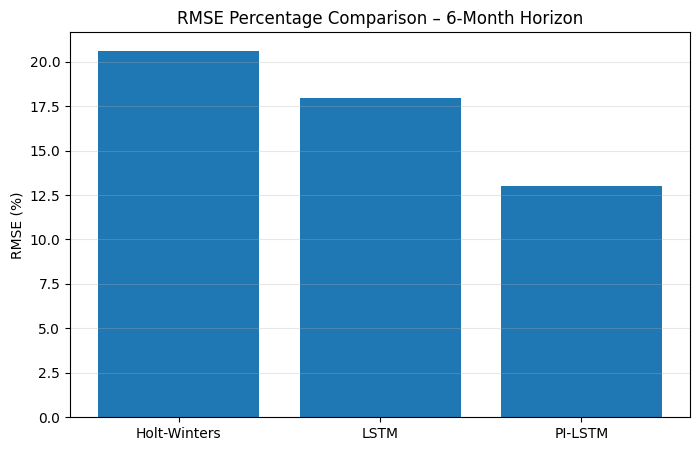

In [21]:
# === FINAL ADJUSTMENT: RMSE IN PERCENTAGE (6 MONTHS) ===
# Definition: RMSE% = (RMSE / average of actual values ​​over the horizon) * 100
# Note: This cell uses the names that already exist in the notebook (y_hw_6m, y_lstm_6m, y_pi_plot / y_pi, y_real_6m)

def rmse_percentual(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    denom = np.mean(y_true)
    return (rmse / denom) * 100 if denom != 0 else np.nan

# --- Robust selection of series (avoids NameError if any name varies) ---
y_true_6m = np.asarray(y_real_6m, dtype=float)

# Holt-Winters
if 'y_hw_6m' in globals():
    y_hw_pred_6m = np.asarray(y_hw_6m, dtype=float)
elif 'y_hw' in globals():
    y_hw_pred_6m = np.asarray(y_hw, dtype=float)[:len(y_true_6m)]
else:
    raise NameError("I couldn't find 'y_hw_6m' or 'y_hw' in the notebook.")

# LSTM
if 'y_lstm_6m' in globals():
    y_lstm_pred_6m = np.asarray(y_lstm_6m, dtype=float)
elif 'preds_lstm_6m' in globals():
    y_lstm_pred_6m = np.asarray(preds_lstm_6m, dtype=float)
elif 'y_lstm' in globals():
    y_lstm_pred_6m = np.asarray(y_lstm, dtype=float)[:len(y_true_6m)]
else:
    raise NameError("I couldn't find 'y_lstm_6m'/'preds_lstm_6m' or 'y_lstm' in the notebook.")

# PI-LSTM
if 'y_pi_plot' in globals() and y_pi_plot is not None:
    y_pilstm_pred_6m = np.asarray(y_pi_plot, dtype=float)[:len(y_true_6m)]
elif 'y_pi' in globals() and y_pi is not None:
    y_pilstm_pred_6m = np.asarray(y_pi, dtype=float)[:len(y_true_6m)]
else:
    raise NameError("I couldn't find 'y_pi_plot' or 'y_pi' with values ​​for PI-LSTM.")

# --- Percentage RMSE (6 months) ---
rmse_hw_pct     = rmse_percentual(y_true_6m, y_hw_pred_6m)
rmse_lstm_pct   = rmse_percentual(y_true_6m, y_lstm_pred_6m)
rmse_pilstm_pct = rmse_percentual(y_true_6m, y_pilstm_pred_6m)

metricas_pct = pd.DataFrame({
    'Modelo': ['Holt-Winters', 'LSTM', 'PI-LSTM'],
    'RMSE_6M_%': [rmse_hw_pct, rmse_lstm_pct, rmse_pilstm_pct]
})

display(metricas_pct)

# === FINAL CHART: RMSE IN PERCENTAGE ===
plt.figure(figsize=(8, 5))
plt.bar(metricas_pct['Modelo'], metricas_pct['RMSE_6M_%'])
plt.ylabel('RMSE (%)')
plt.title('RMSE Percentage Comparison – 6-Month Horizon')
plt.grid(axis='y', alpha=0.3)
plt.show()


In [16]:
# === SPREADSHEET (LSTM) – 6-MONTH HORIZON (MONTH BY MONTH) ===
# Generates a table similar to the PI-LSTM: Actual, Predicted (LSTM), Error, and %Error.

# --- Robust selection of series ---
if 'y_real_6m' in globals():
    y_true_6m = np.asarray(y_real_6m, dtype=float)
elif 'y_real' in globals():
    y_true_6m = np.asarray(y_real, dtype=float)[-6:]
else:
    raise NameError("I couldn't find 'y_real_6m' or 'y_real' in the notebook.")

if 'y_lstm_6m' in globals():
    y_pred_lstm_6m = np.asarray(y_lstm_6m, dtype=float)
elif 'preds_lstm_6m' in globals():
    y_pred_lstm_6m = np.asarray(preds_lstm_6m, dtype=float)
elif 'y_lstm' in globals():
    y_pred_lstm_6m = np.asarray(y_lstm, dtype=float)[-6:]
else:
    raise NameError("I couldn't find 'y_lstm_6m'/'preds_lstm_6m' or 'y_lstm' in the notebook.")

# Ensures the same length.
n = min(len(y_true_6m), len(y_pred_lstm_6m))
y_true_6m = y_true_6m[:n]
y_pred_lstm_6m = y_pred_lstm_6m[:n]

# Month labels (uses test_dates if they exist)
if 'datas_teste' in globals() and len(datas_teste) >= n:
    meses_6m = np.asarray(datas_teste)[:n]
else:
    meses_6m = np.array([f"M{i+1}" for i in range(n)])

# Error in the same pattern as the graphs: prediction - actual
erro_lstm = y_pred_lstm_6m - y_true_6m

# Percentage of error for the month
perc_erro_lstm = np.where(y_true_6m != 0, (erro_lstm / y_true_6m) * 100, np.nan)

spreadsheet_lstm_6m = pd.DataFrame({
    'Mes': meses_6m,
    'Valor_Real': y_true_6m,
    'Valor_Pred_LSTM': y_pred_lstm_6m,
    'Erro_LSTM': erro_lstm,
    'Erro_LSTM_%': perc_erro_lstm
})

display(spreadsheet_lstm_6m)

# Save to CSV
spreadsheet_lstm_6m.to_csv('spreadsheet_lstm_6m.csv', index=False)


,Mes,Valor_Real,Valor_Pred_LSTM,Erro_LSTM,Erro_LSTM_%
0,Jan/2025,1015.0,1533.353918,518.353918,51.069351
1,Feb/2025,1715.0,1494.668522,-220.331478,-12.847316
2,Mar/2025,1380.0,1458.457398,78.457398,5.685319
3,Apr/2025,1250.0,1433.063806,183.063806,14.645104
4,May/2025,1375.0,1419.721911,44.721911,3.252503
5,Jun/2025,1495.0,1417.051982,-77.948018,-5.213914
